# Rubik's Cube Solver 1.0
Uses 4 previous moves and cube state to predict next move to make in CFOP method. 
Trained only from initial scrambled state to F2L done. No purpose in learning OLL or PLL since that is hardcoded (not creative)
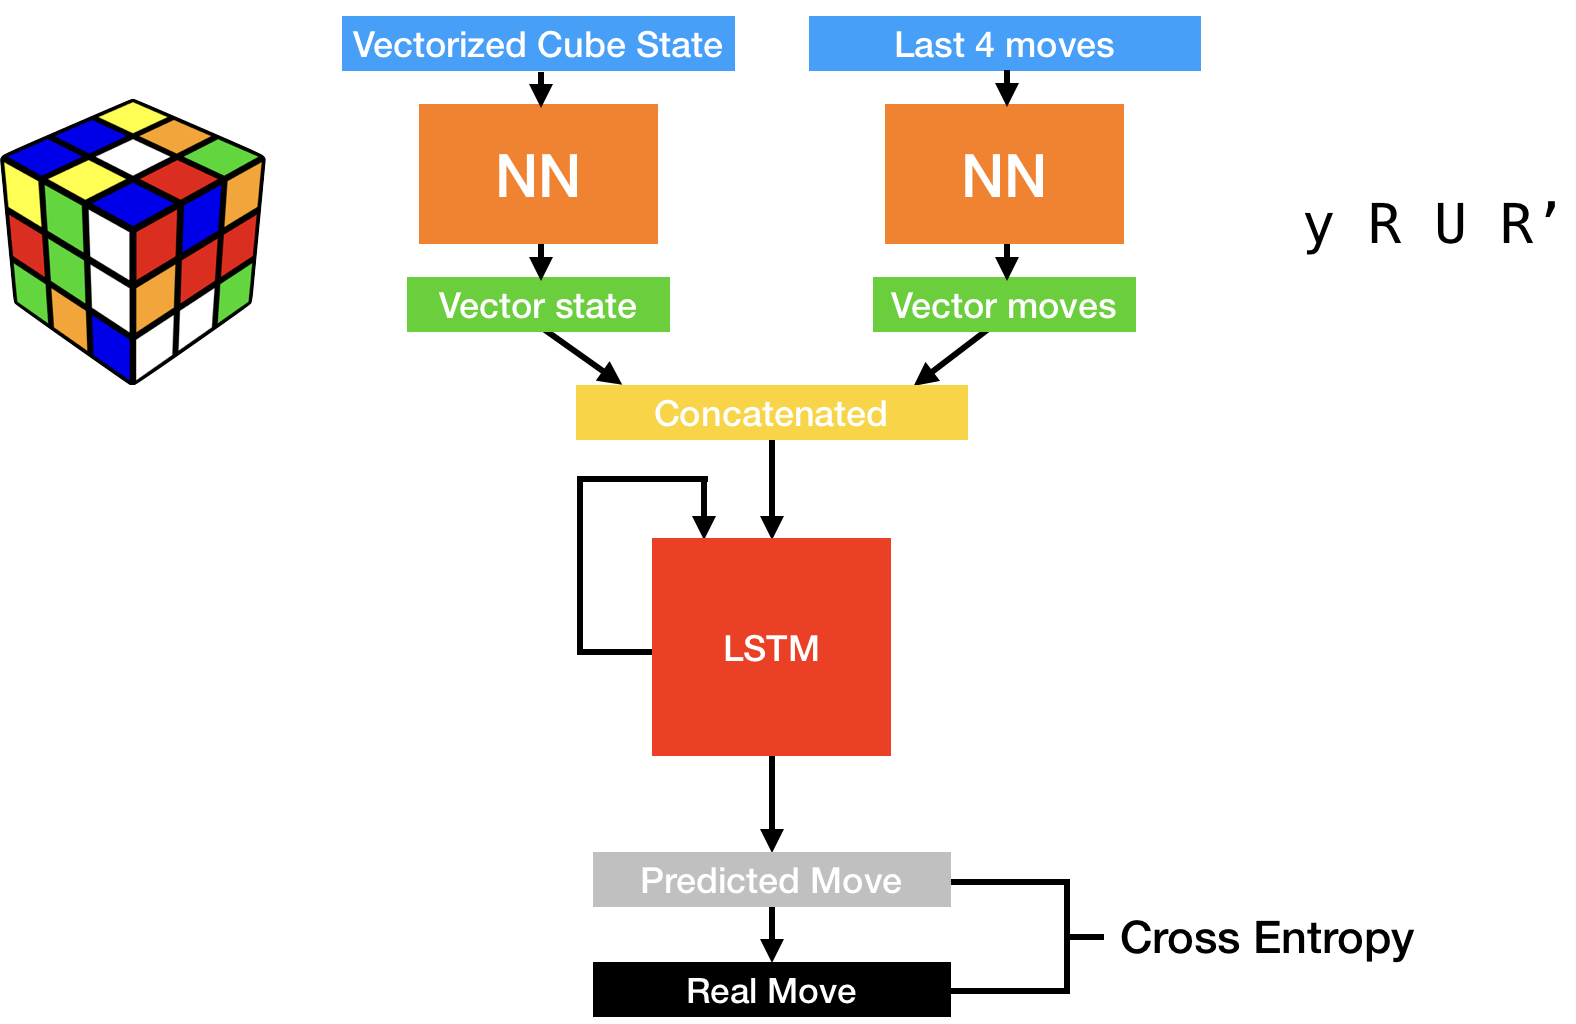

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import pycuber as pc

In [3]:
# Length of vocabulary is 56
move2index =    ["U", "U'", "U2", "u", "u'", "u2", # U moves
                 "F", "F'", "F2", "f", "f'", "f2", # F moves
                 "R", "R'", "R2", "r", "r'", "r2", # R moves
                 "D", "D'", "D2", "d", "d'", "d2", # D moves
                 "B", "B'", "B2", "b", "b'", "b2", # B moves
                 "L", "L'", "L2", "l", "l'", "l2", # L moves
                 "M", "M'", "M2",                  # M moves
                 "S", "S'", "S2",                  # S moves
                 "E", "E'", "E2",                  # E moves
                 "x", "x'", "x2",                  # x rotations
                 "y", "y'", "y2",                  # y rotations
                 "z", "z'", "z2",                  # z rotations
                 "/",                              # stage done
                 "-"]                              # no move 
                 # when beginning solve (-,-,-,R),(-,-,R,u),(-,R,u,D),(R,u,D,F)

In [4]:
# Utilities
def onehot(index, size):
    vector = [0] * size
    vector[index-1] = 1
    return vector

def cubeAsArray(cube):
    faces = ["L", "R", "U", "D", "B", "F"]
    cubeArray = []
    for face in faces:
        face = cube.get_face(face)  # get face, iterate over all squares.
        for x in [0,1,2]:
            for y in [0,1,2]:
                cubeArray.append(str(face[x][y]))

    stickerList = []

    for sticker in cubeArray:
        if   sticker == '[r]':
            stickerList += (onehot(1, 6))
        elif sticker == '[y]':
            stickerList += (onehot(2, 6))
        elif sticker == '[o]':
            stickerList +=(onehot(3, 6))
        elif sticker == '[w]':
            stickerList += (onehot(4, 6))
        elif sticker == '[g]':
            stickerList += (onehot(5, 6))
        elif sticker == '[b]':
            stickerList += (onehot(6, 6))

    return stickerList

def getMetaListOfMoves(data, length):
    """
    Breaks move sequence into all the chunks of 4 needed
    """
    metalist = [0]*len(data)
    
    for i in range(length):
        metalist[i] = (['-']*(length-i-1)) + data[0:i+1]
    
    limit = len(data) - length
    for i in range(limit):
        metalist[i + length] = data[i+1: i+1 + length]

    return metalist

In [12]:
# The Model
class RubiksCubeSolver(nn.Module):
    def __init__(self):
        super(RubiksCubeSolver, self).__init__()
        
        # Cube State 
        self.l1state = nn.Linear(324, 162)
        self.l2state = nn.Linear(162, 81)
        self.l3state = nn.Linear(81, 28)
        
        # Previous 4 Moves
        self.l1moves = nn.Linear(224, 112)
        self.l2moves = nn.Linear(112, 28)
        
        # Next Move LSTM
        self.lstm1nextmove = nn.LSTM(input_size=56, hidden_size=56, num_layers=5)
    
    def forward(self, state, moves, hidden):
        # State
        state = F.relu(self.l1state(state))
        state = F.relu(self.l2state(state))
        state = F.relu(self.l3state(state))
        # Moves
        moves = F.relu(self.l1moves(moves))
        moves = F.relu(self.l2moves(moves))
        # Concatenation
        inputs = torch.cat((state, moves), 0)
        # Next Move
        out, hidden = self.lstm1nextmove(inputs, hidden)
        
        return out, hidden
    
    def init_hidden(self):
        # Initialization of hidden and cell states
        # (num_layers, batch_size, hidden_size)
        return Variable(torch.zeros(5, 1, 56))

# Initialize Model
model = RubiksCubeSolver()
print(model)

RubiksCubeSolver(
  (l1state): Linear(in_features=324, out_features=162, bias=True)
  (l2state): Linear(in_features=162, out_features=81, bias=True)
  (l3state): Linear(in_features=81, out_features=28, bias=True)
  (l1moves): Linear(in_features=224, out_features=112, bias=True)
  (l2moves): Linear(in_features=112, out_features=28, bias=True)
  (lstm1nextmove): LSTM(56, 56, num_layers=5)
)


In [25]:
# Training


# Set loss and optimizer function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Training solve by solve for 2 epochs
for epoch in range(2):
    
    loss = 0
    hidden = model.init_hidden()
    optimizer.zero_grad()
    
    with open('processedSolves.txt') as reconstructions:
        reconstruction = 0
        for line in reconstructions:
            line = line.strip() #strip \n at end of line
            solve = line.split('|')
            scramble = solve[0]
            solution = solve[1]
            solution = solution.split(' ')
            cube = pc.Cube()
            cube(scramble)

            seqsOfMoves = getMetaListOfMoves(solution, 4)
            
            # For input (state, moves, hidden) label (onehotmove) in a solve (line)
            for i in range(len(seqsOfMoves)):
                move = seqsOfMoves[i][3]
                print(move)
                if move != '/':
                    cube(move)
                # State
                state = Variable(torch.Tensor(cubeAsArray(cube))).view(1,-1).view(1,324,-1)
                print(state.size())
                
                # Moves
                onehotmove = Variable(torch.Tensor(onehot(move2index.index(move), 56))).view(1,-1).view(1,56,-1) # label
                print(onehotmove.size())
                
                moves = []
                for turn in range(4):
                    moves += onehot(move2index.index(seqsOfMoves[i][turn]), 56)
                moves = Variable(torch.Tensor(moves)).view(1,-1).view(1,224,-1)
                print(moves.size())
                
                # Model
                outputs = model(state, moves, hidden)
                
                # Loss Function
                optimizer.zero_grad()
                loss += criterion(output, onehotmove)
            
            
            loss.backward()
            optimizer.step()
            
            reconstruction += 1
            if reconstruction % 100 == 0:
                print('solve',reconstruction, ' done.')
            
        print('epoch', epoch, 'done.')
        

y'
torch.Size([1, 324, 1])
torch.Size([1, 56, 1])
torch.Size([1, 224, 1])


RuntimeError: size mismatch, m1: [324 x 1], m2: [324 x 162] at /Users/soumith/code/builder/wheel/pytorch-src/torch/lib/TH/generic/THTensorMath.c:1434